In [223]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from xgboost import XGBRegressor
from sklearn.model_selection import GroupShuffleSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import shap
import optuna
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import seaborn as sns

In [250]:
# Read in formatted dataset
# assume repo root is two levels up from this notebook
ROOT = Path.cwd().parents[1]  # adjust if needed
DATA_DIR = ROOT / "data"

print(DATA_DIR)

print(ROOT)

df = pd.read_parquet(r"../../data/processed_pitches_df_2023-03-30_2025-09-30.parquet")


/Users/matthewgillies/PitchArsenalModelling/data
/Users/matthewgillies/PitchArsenalModelling


In [225]:
df.head()

,pitcher,season,p_throws,pitch_type,arsenal_size,pitches,whiff_pct,CH_HAA,CH_HB,CH_IVB,...,SV_mean_z,SV_pct_in_zone,SV_pct_vs_RHB,SV_rel_x,SV_rel_z,SV_spin,SV_std_x,SV_std_z,SV_usage,SV_velo
0,425794,2023,R,CH,5,89,0.100000,0.9675,-14.02382,8.755955,...,<NA>,<NA>,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,<NA>
1,425794,2023,R,CU,5,546,0.149378,0.9675,-14.02382,8.755955,...,<NA>,<NA>,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,<NA>
2,425794,2023,R,FC,5,404,0.146597,0.9675,-14.02382,8.755955,...,<NA>,<NA>,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,<NA>
3,425794,2023,R,FF,5,178,0.100000,0.9675,-14.02382,8.755955,...,<NA>,<NA>,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,<NA>
4,425794,2023,R,SI,5,560,0.071429,0.9675,-14.02382,8.755955,...,<NA>,<NA>,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,<NA>


In [226]:
df.shape

(8785, 263)

In [227]:
df.isna().sum().sort_values(ascending=False)

SC_pct_in_zone    8778
SC_usage          8778
SC_rel_x          8778
SC_pct_vs_RHB     8778
SC_mean_z         8778
                  ... 
season               0
pitches              0
arsenal_size         0
p_throws             0
pitcher              0
Length: 263, dtype: int64

In [228]:
# drop nas -> not a large proportion
# df = df.dropna()

In [229]:
df.shape

(8785, 263)

In [230]:
# drop duplicates in pitcher/season/pitch_type
df = df.drop_duplicates(subset=["pitcher", "season", "pitch_type"])
df.shape

(8785, 263)

In [231]:
# filter to FF only for initial analysis
ff_df = df[df["pitch_type"] == "CH"]

# filter to min 60 pitches thrown
ff_filtered = ff_df[ff_df['pitches'] > 60]

In [232]:
ff_df.head()

,pitcher,season,p_throws,pitch_type,arsenal_size,pitches,whiff_pct,CH_HAA,CH_HB,CH_IVB,...,SV_mean_z,SV_pct_in_zone,SV_pct_vs_RHB,SV_rel_x,SV_rel_z,SV_spin,SV_std_x,SV_std_z,SV_usage,SV_velo
0,425794,2023,R,CH,5,89,0.100000,0.9675,-14.02382,8.755955,...,<NA>,<NA>,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,<NA>
5,425844,2023,R,CH,6,367,0.191257,0.990465,-13.275531,4.170245,...,<NA>,<NA>,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,<NA>
11,434378,2023,R,CH,4,134,0.245283,1.277241,-15.439701,9.018806,...,<NA>,<NA>,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,<NA>
12,434378,2024,R,CH,4,160,0.256098,1.365148,-13.431,9.70125,...,<NA>,<NA>,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,<NA>
13,434378,2025,R,CH,5,228,0.281553,1.568254,-12.954737,9.280526,...,<NA>,<NA>,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,<NA>


In [233]:
ff_df.shape

(1134, 263)

In [234]:
# plot top 10 correlations with whiff_rate
correlations = ff_filtered.select_dtypes("number").corr()["whiff_pct"].abs().sort_values(ascending=False
)
top_10_features = correlations.index[1:11]  # exclude whiff_rate itself
print("Top 10 features correlated with whiff_rate:")
print(top_10_features)

Top 10 features correlated with whiff_rate:
Index(['CS_pct_in_zone', 'CS_std_z', 'CS_pct_vs_RHB', 'CS_spin', 'CS_rel_z',
       'CS_mean_z', 'CS_mean_x', 'CS_VAA', 'CS_IVB', 'CS_HB'],
      dtype='object')


In [235]:
# create correlation heatmap for features with traget (whiff_pct)
# import seaborn as sns
# corr = ff_df.select_dtypes(include=[np.number]).corr()
# plt.figure(figsize=(24, 24))
# sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
# plt.title("Feature Correlation Heatmap")
# plt.show()

In [236]:
def objective(trial, X_train, y_train, X_valid, y_valid):
    model_type = trial.suggest_categorical(
        "model_type", ["xgboost", "lightgbm", "random_forest"]
    )

    if model_type == "xgboost":
        params = {
            "n_estimators": trial.suggest_int("xgb_n_estimators", 200, 2000),
            "max_depth": trial.suggest_int("xgb_max_depth", 3, 12),
            "learning_rate": trial.suggest_float("xgb_learning_rate", 0.01, 0.3, log=True),
            "subsample": trial.suggest_float("xgb_subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("xgb_colsample_bytree", 0.5, 1.0),
            "min_child_weight": trial.suggest_float("xgb_min_child_weight", 1e-3, 50.0, log=True),
            "gamma": trial.suggest_float("xgb_gamma", 0.0, 10.0),
            "reg_alpha": trial.suggest_float("xgb_reg_alpha", 1e-8, 10.0, log=True),
            "reg_lambda": trial.suggest_float("xgb_reg_lambda", 1e-8, 10.0, log=True),
            "random_state": 42,
            "n_jobs": -1,
        }
        model = XGBRegressor(**params)

    elif model_type == "lightgbm":
        params = {
            "n_estimators": trial.suggest_int("lgb_n_estimators", 200, 5000),
            "learning_rate": trial.suggest_float("lgb_learning_rate", 0.005, 0.3, log=True),
            "num_leaves": trial.suggest_int("lgb_num_leaves", 16, 512),
            "max_depth": trial.suggest_int("lgb_max_depth", -1, 16),
            "min_child_samples": trial.suggest_int("lgb_min_child_samples", 5, 200),
            "subsample": trial.suggest_float("lgb_subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("lgb_colsample_bytree", 0.5, 1.0),
            "reg_alpha": trial.suggest_float("lgb_reg_alpha", 1e-8, 10.0, log=True),
            "reg_lambda": trial.suggest_float("lgb_reg_lambda", 1e-8, 10.0, log=True),
            "random_state": 42,
            "n_jobs": -1,
            "verbose": -1,
        }
        model = LGBMRegressor(**params)

    else:  # random_forest
        params = {
            "n_estimators": trial.suggest_int("rf_n_estimators", 200, 2000),
            "max_depth": trial.suggest_int("rf_max_depth", 2, 50),
            "min_samples_split": trial.suggest_int("rf_min_samples_split", 2, 20),
            "min_samples_leaf": trial.suggest_int("rf_min_samples_leaf", 1, 20),
            "max_features": trial.suggest_categorical("rf_max_features", ["sqrt", "log2", 0.5, 1.0]),
            "bootstrap": trial.suggest_categorical("rf_bootstrap", [True, False]),
            "random_state": 42,
            "n_jobs": -1,
        }
        model = RandomForestRegressor(**params)

    # Fit
    if model_type == "catboost":
        model.fit(X_train, y_train, eval_set=(X_valid, y_valid), use_best_model=False)
    else:
        model.fit(X_train, y_train)

    # Evaluate
    y_pred = model.predict(X_valid)
    rmse = float(np.sqrt(mean_squared_error(y_valid, y_pred)))
    return rmse



In [237]:
# develop base xgboost workflow 
cat_cols = ['p_throws'] + [col for col in ff_df.columns if col.startswith('has_')]

target = "whiff_pct"

# 1) train/val split by pitcher - when we have multiple seasons with same pitches
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(gss.split(ff_df, groups=ff_df["pitcher"]))

train = ff_df.iloc[train_idx].copy()
val   = ff_df.iloc[val_idx].copy()

# 2) choose features (exclude ids + targets)
drop_cols = ["pitcher", "season", "pitch_type", "whiff_pct", "csw_pct"]
X_train = train.drop(columns=[c for c in drop_cols if c in train.columns])
X_val   = val.drop(columns=[c for c in drop_cols if c in val.columns])

y_train = train[target].values
y_val   = val[target].values

# 3) one-hot categorical cols (simple + reliable)
X_train = pd.get_dummies(X_train, columns=cat_cols, dummy_na=True)
X_val   = pd.get_dummies(X_val, columns=cat_cols, dummy_na=True)

# align columns
X_train, X_val = X_train.align(X_val, join="left", axis=1, fill_value=0)

# 4) sample weights to reflect stability of rate targets
w_train = train["pitches"].values  # or np.sqrt(train["pitches"].values)



study = optuna.create_study(direction="minimize") 
study.optimize(lambda trial: objective(trial, X_train, y_train, X_val, y_val), n_trials=50)

print("Best trial:")
trial = study.best_trial
print("  RMSE: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


[I 2026-02-01 14:48:38,102] A new study created in memory with name: no-name-14f9828e-ce6d-44a7-89b6-8eb0188d6a02
[I 2026-02-01 14:48:39,513] Trial 0 finished with value: 0.09464369926386135 and parameters: {'model_type': 'random_forest', 'rf_n_estimators': 458, 'rf_max_depth': 11, 'rf_min_samples_split': 16, 'rf_min_samples_leaf': 13, 'rf_max_features': 0.5, 'rf_bootstrap': True}. Best is trial 0 with value: 0.09464369926386135.
[I 2026-02-01 14:48:41,480] Trial 1 finished with value: 0.10029009995103175 and parameters: {'model_type': 'random_forest', 'rf_n_estimators': 1890, 'rf_max_depth': 48, 'rf_min_samples_split': 14, 'rf_min_samples_leaf': 9, 'rf_max_features': 'log2', 'rf_bootstrap': True}. Best is trial 0 with value: 0.09464369926386135.
[I 2026-02-01 14:48:43,494] Trial 2 finished with value: 0.10709861087796468 and parameters: {'model_type': 'xgboost', 'xgb_n_estimators': 1318, 'xgb_max_depth': 3, 'xgb_learning_rate': 0.062386641910405445, 'xgb_subsample': 0.9418419271434288

Best trial:
  RMSE: 0.09202274236071893
  Params: 
    model_type: lightgbm
    lgb_n_estimators: 2847
    lgb_learning_rate: 0.009692979499470006
    lgb_num_leaves: 290
    lgb_max_depth: 0
    lgb_min_child_samples: 200
    lgb_subsample: 0.8179786495518304
    lgb_colsample_bytree: 0.7371991127089456
    lgb_reg_alpha: 2.5748113328400685e-07
    lgb_reg_lambda: 7.345468632201671e-05


In [238]:
trial.params

{'model_type': 'lightgbm',
 'lgb_n_estimators': 2847,
 'lgb_learning_rate': 0.009692979499470006,
 'lgb_num_leaves': 290,
 'lgb_max_depth': 0,
 'lgb_min_child_samples': 200,
 'lgb_subsample': 0.8179786495518304,
 'lgb_colsample_bytree': 0.7371991127089456,
 'lgb_reg_alpha': 2.5748113328400685e-07,
 'lgb_reg_lambda': 7.345468632201671e-05}

In [239]:
# define model with best params
best_params = trial.params

if best_params['model_type']=='xgboost':
    best_params = {k.replace('xgb_',''):v for k,v in best_params.items() if k.startswith('xgb_')}
    model = XGBRegressor(**best_params, random_state=42)
elif best_params['model_type']=='lightgbm':
    best_params = {k.replace('lgb_',''):v for k,v in best_params.items() if k.startswith('lgb_')}
    model = LGBMRegressor(**best_params, random_state=42)
elif best_params['model_type']=='random_forest':
    best_params = {k.replace('rf_',''):v for k,v in best_params.items() if k.startswith('rf_')}
    model = RandomForestRegressor(**best_params, random_state=42)

model.fit(X_train, y_train)

# train metrics:

train_pred = model.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
train_r2 = r2_score(y_train, train_pred)
print("Train RMSE:", train_rmse, "R2:", train_r2)

pred = model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, pred))
r2 = r2_score(y_val, pred)

print("RMSE:", rmse, "R2:", r2)

Train RMSE: 0.06293052176567936 R2: 0.6248795851370612
RMSE: 0.09202274236071893 R2: 0.23797030227232052


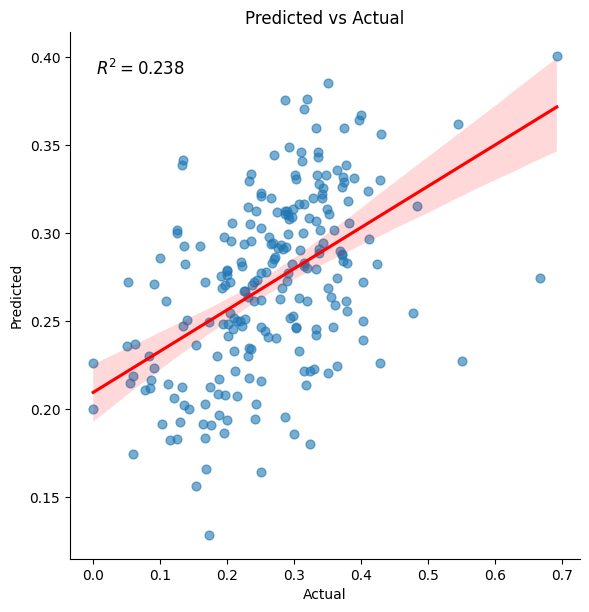

In [240]:
# seaborn lmplot of predicted vs actual
# Build plotting dataframe
plot_df = pd.DataFrame({
    "actual": y_val,
    "predicted": pred
})

# Plot
g = sns.lmplot(
    data=plot_df,
    x="actual",
    y="predicted",
    height=6,
    aspect=1,
    scatter_kws={"alpha": 0.6, "s": 40},
    line_kws={"color": "red"}
)

# Annotate R^2
plt.text(
    0.05, 0.95,
    f"$R^2 = {r2:.3f}$",
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment="top"
)

plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual")

plt.show()



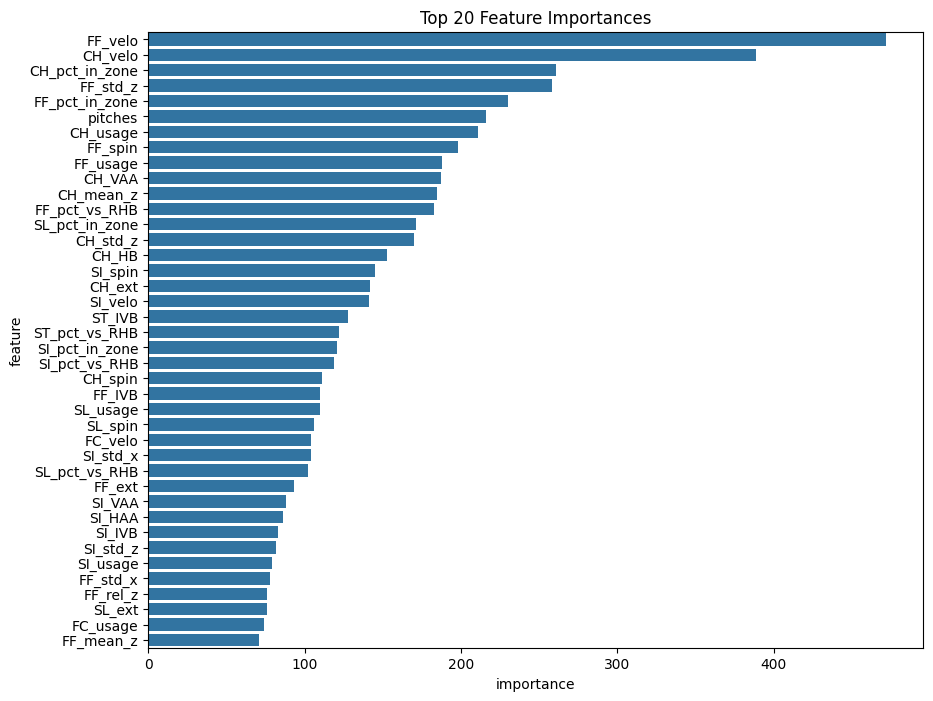

In [241]:
# plot feature importance
importances = model.feature_importances_
feature_names = X_train.columns
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=importance_df.head(40))
plt.title("Top 20 Feature Importances")
plt.show()

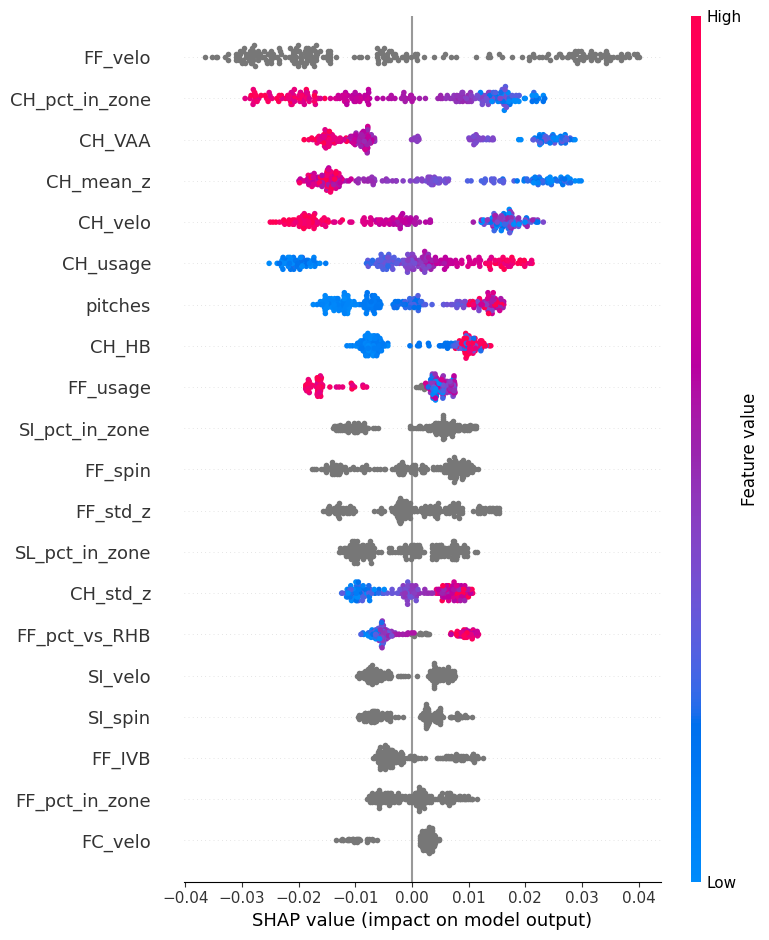

In [242]:
# shap explainer and summary plot
explainer = shap.Explainer(model)
shap_values = explainer(X_val)
shap.summary_plot(shap_values, X_val)

# Workflow to look at individual player predictions

In [243]:
from pybaseball import playerid_lookup

def get_mlbam_id(first: str, last: str) -> int:
    """
    Returns MLBAM id (key_mlbam) for a player name.
    If multiple results, returns the first row (you can disambiguate by birth year if needed).
    """
    res = playerid_lookup(last, first)
    if res.empty:
        raise ValueError(f"No player found for {first} {last}")

    # key_mlbam is what Statcast 'pitcher' column uses
    mlbam = res.iloc[0]["key_mlbam"]
    if pd.isna(mlbam):
        raise ValueError(f"Found player but no MLBAM id for {first} {last}")

    return int(mlbam)

# Example:
pitcher_id = get_mlbam_id("Gerrit", "Cole")
pitcher_id


543037

In [244]:
import pandas as pd

def preprocess_single_row(row_df, cat_cols, model_columns):
    """
    Preprocess a single-row dataframe to match X_train exactly.
    """
    X = row_df.copy()

    # ensure categoricals are strings and fill NA
    for c in cat_cols:
        if c in X.columns:
            X[c] = X[c].astype("string").fillna("NONE")

    # one-hot encode
    X = pd.get_dummies(X, columns=cat_cols, dummy_na=True)

    # align columns to training matrix
    X = X.reindex(columns=model_columns, fill_value=0)

    return X



In [245]:
import shap
import matplotlib.pyplot as plt
from pybaseball import playerid_lookup

def explain_one_prediction(
    features_df,
    model,
    model_columns,
    cat_cols,
    first,
    last,
    season,
    pitch_type="FF"
):
    # --- lookup MLBAM id ---
    pid_df = playerid_lookup(last, first)
    if pid_df.empty:
        raise ValueError(f"No player found for {first} {last}")

    pitcher_id = int(pid_df.iloc[0]["key_mlbam"])

    # --- select row ---
    row = features_df[
        (features_df["pitcher"] == pitcher_id) &
        (features_df["season"] == season) &
        (features_df["pitch_type"] == pitch_type)
    ].copy()

    if row.empty:
        raise ValueError(f"No row for {first} {last}, {season}, {pitch_type}")

    # if somehow duplicated, take most-used
    if len(row) > 1:
        row = row.loc[[row["pitches"].idxmax()]]

    # --- drop non-features (exactly like training) ---
    drop_cols = ["pitcher", "season", "pitch_type", "whiff_pct", "csw_pct"]
    X_pre = row.drop(columns=[c for c in drop_cols if c in row.columns])

    # --- preprocess to match model ---
    X_row = preprocess_single_row(
        X_pre,
        cat_cols=cat_cols,
        model_columns=model_columns
    )

    # --- prediction ---
    pred = float(model.predict(X_row)[0])

    # --- SHAP ---
    explainer = shap.TreeExplainer(model)
    shap_values = explainer(X_row)

    # Waterfall plot (best for single prediction)
    shap.plots.waterfall(shap_values[0], max_display=20)

    return {
        "pitcher_id": pitcher_id,
        "season": season,
        "pitch_type": pitch_type,
        "prediction": pred,
        "raw_row": row,
        "X_row": X_row,
        "shap_values": shap_values
    }



In [246]:
# Get pitchers from X_val:

val.head()

,pitcher,season,p_throws,pitch_type,arsenal_size,pitches,whiff_pct,CH_HAA,CH_HB,CH_IVB,...,SV_mean_z,SV_pct_in_zone,SV_pct_vs_RHB,SV_rel_x,SV_rel_z,SV_spin,SV_std_x,SV_std_z,SV_usage,SV_velo
11,434378,2023,R,CH,4,134,0.245283,1.277241,-15.439701,9.018806,...,<NA>,<NA>,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,<NA>
12,434378,2024,R,CH,4,160,0.256098,1.365148,-13.431,9.70125,...,<NA>,<NA>,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,<NA>
13,434378,2025,R,CH,5,228,0.281553,1.568254,-12.954737,9.280526,...,<NA>,<NA>,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,<NA>
60,450203,2023,R,CH,5,292,0.315385,2.163772,-17.245479,0.292192,...,<NA>,<NA>,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,<NA>
61,450203,2024,R,CH,5,313,0.329268,2.18006,-17.18722,0.220831,...,<NA>,<NA>,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,<NA>


In [247]:
# get playerr name from id: 
from pybaseball import playerid_reverse_lookup

# single id
for i in range(len(val)):
    print(val.iloc[i])
    print(playerid_reverse_lookup([val['pitcher'].iloc[i]], key_type="mlbam")[['name_first', 'name_last']])


pitcher         434378
season            2023
p_throws             R
pitch_type          CH
arsenal_size         4
                 ...  
SV_spin           <NA>
SV_std_x          <NA>
SV_std_z          <NA>
SV_usage           NaN
SV_velo           <NA>
Name: 11, Length: 263, dtype: object
  name_first  name_last
0     justin  verlander
pitcher         434378
season            2024
p_throws             R
pitch_type          CH
arsenal_size         4
                 ...  
SV_spin           <NA>
SV_std_x          <NA>
SV_std_z          <NA>
SV_usage           NaN
SV_velo           <NA>
Name: 12, Length: 263, dtype: object
  name_first  name_last
0     justin  verlander
pitcher         434378
season            2025
p_throws             R
pitch_type          CH
arsenal_size         5
                 ...  
SV_spin           <NA>
SV_std_x          <NA>
SV_std_z          <NA>
SV_usage           NaN
SV_velo           <NA>
Name: 13, Length: 263, dtype: object
  name_first  name_last
0     just

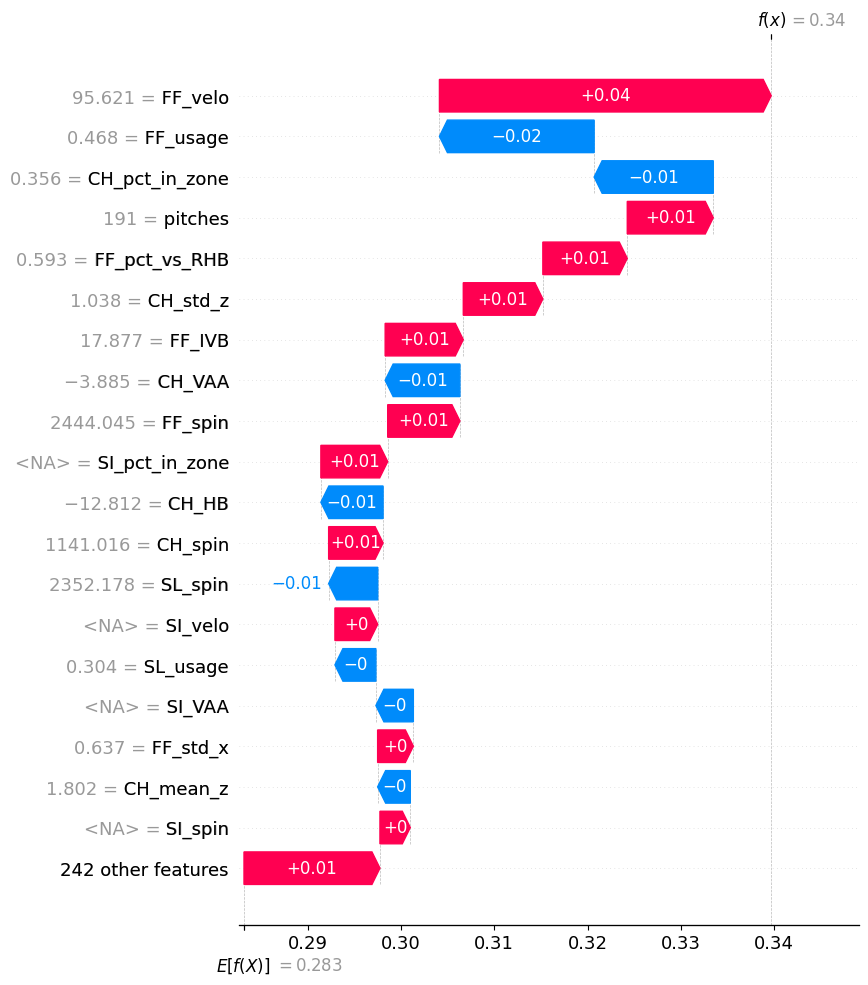

Predicted SL whiff%: 0.3396750697690548


,pitcher,season,p_throws,pitch_type,arsenal_size,pitches,whiff_pct,CH_HAA,CH_HB,CH_IVB,...,SV_mean_z,SV_pct_in_zone,SV_pct_vs_RHB,SV_rel_x,SV_rel_z,SV_spin,SV_std_x,SV_std_z,SV_usage,SV_velo
7766,686218,2025,R,CH,4,191,0.270833,1.123878,-12.811728,0.72,...,<NA>,<NA>,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,<NA>


In [249]:
model_columns = X_train.columns

out = explain_one_prediction(
    features_df=df,   # your full season-level table
    model=model,
    model_columns=model_columns,
    cat_cols=cat_cols,
    first="Emmet",
    last="Sheehan",
    season=2025,
    pitch_type="CH"
)

print("Predicted SL whiff%:", out["prediction"])
out["raw_row"]
